# YouTube URL Analysis

## Preface
### Data descriptions

In [41]:
#sample_size = 100000000 # specifies the sample size
sample_size = 100000 # specifies the sample size
limit = 15  # specifies the number of elements in lists and graphs
n_cores = 12 # number of cores to use for parallelization

url_columns = ["id","hash","channelId","publishedAt_urls","url","resolvedUrl","domain","resolved","dead","status_code"]
video_columns = ["id","hash","channelId","channelTitle","publishedAt","title","description","tags","categoryId","defaultLanguage","defaultAudioLanguage","duration","dimension","definition","caption","licensedContent","allowedIn","blockedIn","viewCount","likeCount","dislikeCount","favoriteCount","commentCount","requesttime"]
channel_columns = ["id","title","description","subscriberCount","videoCount","commentCount","viewCount","featuring","subscribing","country","publishedAt","daysactive","keywords","topics","wikitopics"]

### Import necessary modules

In [42]:
import numpy as np
import pandas as pd
import csv
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(14,8.27)})
from multiprocessing import Pool

### Load data

In [43]:
# load URLs csv
pd_url_data = pd.read_csv('sample_' + str(sample_size) + '.csv')
pd_url_data.columns = url_columns

In [44]:
# load list of icann tlds and stlds
from icann_domains import icann_domains
pd_icann_domains = pd.Series(icann_domains)
pd_icann_domains_stld = pd_icann_domains[pd_icann_domains.str.contains("\.")]  # filter for second/third/... level tld
pd_icann_domains_stld = '.' + pd_icann_domains_stld.astype(str) # make sure we will filter on stld, rather than part of domain


### Clean data

In [45]:
import re

# function that checks whether a URL ends with an icann stld and extracts proper host name
# @todo, super costly function. See whether it can be improved
def get_host(url):
    try:
        if url.endswith(tuple(pd_icann_domains_stld)): # check whether url ends in stld
            stld_found = next((stld for stld in pd_icann_domains_stld if url.endswith(str(stld))), None)  # find which stld it ends with
            if stld_found is not None:
                host = re.sub(".*?([^.]+\\" + stld_found + ")$", r"\1", url)  # get host as non-dotted word before (and incl) stld
                return host
        return re.sub('.*?([^.]+\.[^.]+)$', r"\1", url)
    except AttributeError:
        return ''

# function to clean data: parse as date, clean up URLs, remove slashes, extract host
def clean_data(df):
    # add year column, based on publishedAt
    df['year'] = pd.to_datetime(df["publishedAt_urls"]).dt.year
    df['date'] = pd.to_datetime(df["publishedAt_urls"]).dt.date
    
    # remove trailing slash
    df.replace({'resolvedUrl': r'/\)?$'}, {'resolvedUrl':''}, regex=True, inplace=True)
    
    # override domain from URL extraction
    df.drop('domain', axis=1)
    df['domain'] = df['resolvedUrl'].replace('https?://([^/:#]+).*', r'\1', regex=True)  # extract full domain (don't rely on extracted stuff in db)

    # remove all www. or www2.
    df.replace({'domain': r'^www2?\.'}, {'domain': ''}, regex=True, inplace=True)

    # replace youtu.be by youtube.com
    df.replace({'domain': 'youtu.be'}, {'domain': 'youtube.com'}, regex=True, inplace=True)
    
    # replace all open.spotify.com by spotify.com
    # df.replace({'domain': r'^open\.spotify'}, {'domain': 'spotify'}, regex=True, inplace=True)
    
    # get host based on ican (s)tlds
    # df['hasSTLD'] = df['domain'].str.endswith(tuple(pd_icann_domains_stld)) # mark 
    df['host'] = df['domain'].apply(get_host)
    
    return df

# function to parallelize dataframe computation
def parallelize_dataframe(df, func, n_cores):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df


pd_url_data = parallelize_dataframe(pd_url_data, clean_data, n_cores)

# skip everything before 1 december 2019
pd_url_data = pd_url_data[pd_url_data['date'] < datetime.date(year=2019, month=12, day=1)]


# Generic analysis

In [46]:
print("min date: %s, max date: %s\n" % (min(pd_url_data.date),max(pd_url_data.date)))
print("Basic stats on int/float columns")
print(pd_url_data.describe())

min date: 2005-12-19, max date: 2019-11-30

Basic stats on int/float columns
                 id      resolved          dead   status_code          year
count  9.887400e+04  98874.000000  98874.000000  34653.000000  98874.000000
mean   2.885530e+08      0.842790      0.035672    224.943180   2016.883953
std    1.667773e+08      0.364001      0.185471     92.657309      2.005450
min    2.200000e+02      0.000000      0.000000      0.000000   2005.000000
25%    1.441704e+08      1.000000      0.000000    200.000000   2016.000000
50%    2.881955e+08      1.000000      0.000000    200.000000   2017.000000
75%    4.328208e+08      1.000000      0.000000    200.000000   2018.000000
max    5.777342e+08      1.000000      1.000000    999.000000   2019.000000


## Check 'dead' URLs + how many have not yet been checked 
When less than 5%, just leave it as is

@todo: too many unchecked URLs

In [47]:
# count URLs marked as dead on expansion and sort in reverse
pd_url_data_dead = len(pd_url_data.query("dead==1"))
# count total number of URLs
total = len(pd_url_data)
# calculate percentage
percent_dead = round(pd_url_data_dead/total*100,2) 
# print percentage
print("Total URLS: %s, of which %s (%s%%) dead" % (total,pd_url_data_dead,percent_dead)) 

# unchecked if resolved = 0 and dead = 0
pd_url_data_unchecked = len(pd_url_data.query('resolved==0 & dead==0'))
percent_unchecked = round(pd_url_data_unchecked/total*100,2)
print("Total URLS: %s, of which %s (%s%%) NOT yet checked" % (total,pd_url_data_unchecked,percent_unchecked)) 

Total URLS: 98874, of which 3527 (3.57%) dead
Total URLS: 98874, of which 12056 (12.19%) NOT yet checked


## Basic stats (based on videos, not channels)
### Top domains

In [48]:
# add count column
pd_url_data['count'] = 1 
# count domains in URLs data set and sort in reverse
pd_url_data_groupedDomain = pd_url_data.groupby(["domain"]).count()['count'].sort_values(ascending=False) 
# print header
print("Top %s domains" % (limit)) 
# print most used domains overall
print(pd_url_data_groupedDomain.head(limit)) 

Top 15 domains
domain
youtube.com            31265
facebook.com           11018
twitter.com             9091
instagram.com           5232
plus.google.com         1296
play.google.com         1003
vk.com                   951
twitch.tv                941
soundcloud.com           550
amazon.com               466
itunes.apple.com         437
accounts.google.com      434
patreon.com              356
pinterest.com            355
apps.apple.com           297
Name: count, dtype: int64


### Top hosts

In [49]:
# add count column
pd_url_data['count'] = 1 
# count hosts in URLs data set and sort in reverse
pd_url_data_groupedHost = pd_url_data.groupby(["host"]).count()['count'].sort_values(ascending=False)
del pd_url_data_groupedHost[""] # remove hosts for URLs that have not been resolved yet
# print header
print("Top %s hosts" % (limit)) 
# print most used domains overall
print(pd_url_data_groupedHost.head(limit)) 

Top 15 hosts
host
youtube.com       31351
facebook.com      11176
twitter.com        9108
instagram.com      5232
google.com         3117
twitch.tv           975
vk.com              959
apple.com           802
soundcloud.com      552
amazon.com          472
pinterest.com       427
patreon.com         356
tumblr.com          300
amazon.de           286
discord.gg          264
Name: count, dtype: int64


### Top deep links

In [50]:
# reset count column
pd_url_data['count'] = 1 
# count resolved deep links in URLs data set and sort in reverse
pd_url_data_groupedUrl = pd_url_data.groupby(["resolvedUrl"]).count()['count'].sort_values(ascending=False) 
# print header
print("Top %s resolvedUrl" % (limit)) 
# print most used deep links
print(pd_url_data_groupedUrl.head(limit)) 

Top 15 resolvedUrl
resolvedUrl
https://www.zee5.com                                     128
https://www.youtube.com/error?src=404                     83
https://www.youtube.com/user/euronewsnetwork/channels     80
https://unacademy.com/unavailable                         77
https://creativecommons.org/licenses/by/4.0               70
http://incompetech.com                                    67
https://www.facebook.com/euronews                         63
https://twitter.com/ZEE5India                             58
https://www.youtube.com/playlist?list...                  55
https://datinglogic.net/forums/forum/qa                   54
https://www.facebook.com/ZEE5                             54
http://creativecommons.org/licenses/by/3.0                51
http://www.epidemicsound.com                              50
http://vod.sbs.co.kr                                      49
https://www.instagram.com/zee5                            47
Name: count, dtype: int64


### Top TLDs

In [51]:
# reset count column
pd_url_data['count'] = 1 
# make TLD column based on domain
pd_url_data['tld'] = pd_url_data['domain'].str.replace('^.*\.', '', regex=True) 
# count TLDs used and sort in reverse
pd_url_data_groupedTld = pd_url_data.groupby(["tld"]).count()['count'].sort_values(ascending=False)
# print header
print("Top %s TLDs" % (limit))
# print most used TLDs
print(pd_url_data_groupedTld.head(limit))

Top 15 TLDs
tld
com    74308
tv      1666
net      652
org      508
in       487
de       474
me       407
ru       383
br       326
kr       311
gg       285
jp       235
co       182
st       181
uk       172
Name: count, dtype: int64


### Top domains per TLD

In [52]:
# for each tld, get limit domain
print("Top domains per TLD")
for tld in pd_url_data_groupedTld.head(limit).keys():
    top_domains_for_tld = pd_url_data[pd_url_data['tld']==tld].groupby(['tld','domain'])['hash'].nunique().sort_values(ascending=False)
    print(top_domains_for_tld[:limit])
    

Top domains per TLD
tld  domain             
com  youtube.com            31233
     facebook.com           11018
     twitter.com             9091
     instagram.com           5232
     plus.google.com         1296
     play.google.com         1003
     vk.com                   951
     soundcloud.com           550
     amazon.com               466
     itunes.apple.com         437
     accounts.google.com      434
     patreon.com              356
     pinterest.com            355
     apps.apple.com           297
     google.com               214
Name: hash, dtype: int64
tld  domain               
tv   twitch.tv                941
     espreso.tv                23
     tfc.tv                    23
     city42.tv                 20
     ns7.tv                    18
     lahorenews.tv             18
     beritasatu.tv             17
     vizionplus.tv             17
     britishpathe.tv           15
     samaa.tv                  15
     alghad.tv                 14
     gtrk.tv       

# Monetization

## Allowed merch and monetization on Github (by Bernhard)

In [53]:
# import merch and crowd lists
from allowed_3rdparty import merch, crowd
print("Number of merch sites: %s" % (len(merch)))
print("Number of crowd sites: %s" % (len(crowd)))

# add boolean column to pd_url_data based on presence in lists
pd_url_data["crowd"] = np.where(pd_url_data["domain"].isin(crowd), True, False)
pd_url_data["merch"] = np.where(pd_url_data["domain"].isin(merch), True, False)

Number of merch sites: 191
Number of crowd sites: 85


In [54]:
from allowed_3rdparty import monetization_oscar, monetization_extra
print("Number of monetization_oscar sites: %s" % (len(monetization_oscar)))
print("Number of monetization_extra sites: %s" % (len(monetization_extra)))

# add boolean column to pd_url_data based on presence in lists
pd_url_data["monetization_oscar"] = np.where(pd_url_data["host"].isin(monetization_oscar), True, False) # Warning! On host instead of domain, because too much in sub-domains
pd_url_data["monetization_extra"] = np.where(pd_url_data["host"].isin(monetization_extra), True, False) # Warning! On host instead of domain, because too much happened in sub-domains

Number of monetization_oscar sites: 82
Number of monetization_extra sites: 7


In [55]:
# find possible extra monetization domains 
pd_url_data['count'] = 1 # reset count column
monetization_domains_oscar = pd_url_data[pd_url_data.host.str.contains('amazon\.|amazonaws|getshirts|airbnb|movavi|audible|joinhoney|twitch|tripadvisor|shopstyle|adobe|sellfy|clickfunnels|clickbank|etsy|bluehost|shareasale|hubspot|sendinblue|rakutenmarketing|adworkmedia|jvzoo|markethealth|maxbounty|ebay|bhcosmetics|affiliateprograms|sigma-beauty|shopify|agoda|jimpartners|ipage|media\.net|leadpages', regex=True, na=False)].groupby('host').count()['count'].sort_values(ascending=False).reset_index()
print("Possible extra monetization oscar:")
for row_oscar in monetization_domains_oscar['host']:
    if row_oscar not in monetization_oscar:
        print("'%s'," % row_oscar)
print("")

pd_url_data['count'] = 1 # reset count column
monetization_domains_extra = pd_url_data[pd_url_data.host.str.contains('banggood|aliexpress|paypal|skillshare', regex= True, na=False)].groupby('host').count()['count'].sort_values(ascending=False).reset_index()
print("Possible extra monetization extra:")
for row in monetization_domains_extra['host']:
    if row not in monetization_extra:
        print("'%s',"%row)
print("")


Possible extra monetization oscar:
'joinhoney.com',

Possible extra monetization extra:



## Load channel data

In [56]:
# load channel data
pd_channel_data = pd.read_csv('channel_data/channels_from_jsoncache_100k_update.csv')
pd_channel_data.columns = channel_columns

# join with url data on channelId
pd_url_data = pd_url_data.join(pd_channel_data.set_index('id'), on='channelId', lsuffix='_urls', rsuffix='_channel')

## Percentage of videos that have at least one merchandise or one crowd-funding link.

In [57]:
# make a column where at least one of monetized or crowd is true
monetized = pd_url_data['merch'] | pd_url_data['crowd'] 
pd_url_data['monetized'] = monetized

# get number of video ids where monetized = True
monetized_videos = pd_url_data[pd_url_data['monetized']==True]['hash'].unique()
monetized_video_number = len(monetized_videos)
total_video_number = len(pd_url_data['hash'].unique())
percent_video_monetized = round(monetized_video_number/total_video_number*100,2)
# do the same for channels
monetized_channels = pd_url_data[pd_url_data['monetized']==True]['channelId'].unique()
monetized_channel_number = len(monetized_channels)
total_channel_number = len(pd_url_data['channelId'].unique())
percent_channel_monetized = round(monetized_channel_number/total_channel_number*100,2)

print("%s videos are monetized out of %s total videos, that is %s%%" % (monetized_video_number,total_video_number,percent_video_monetized))
print("%s channels are monetized out of %s total channels, that is %s%%" % (monetized_channel_number,total_channel_number,percent_channel_monetized))

1845 videos are monetized out of 98746 total videos, that is 1.87%
1393 channels are monetized out of 31154 total channels, that is 4.47%


### Channel and domain counts

In [58]:
# count unique videos for each channel
videoCountForChannel = pd_url_data.groupby('channelId')['hash'].nunique()
# add videoCountForChannel as column
pd_url_data['videoCountForChannel'] = pd_url_data['channelId'].map(videoCountForChannel)

# count unique videos for each domain
videoCountForDomain = pd_url_data.groupby('domain')['hash'].nunique()
# add videoCountForDomain as column
pd_url_data['videoCountForDomain'] = pd_url_data['domain'].map(videoCountForDomain)

# count unique channels for domain
channelCountForDomain = pd_url_data.groupby('domain')['channelId'].nunique()
# add channelCountForDomain as column
pd_url_data['channelCountForDomain'] = pd_url_data['domain'].map(channelCountForDomain)

# add log(channels/videos) for domains
pd_url_data['channelDivVideoForDomain'] = pd_url_data['channelCountForDomain']/pd_url_data['videoCountForDomain']

## Number of YouTube videos per domain, per monetization type. As well as graph of domains per year, per monetization type
Beware: below calculations assume that merch or crowd URLs are only mentioned once per video


crowd domain count
                domain  channelCountForDomain  videoCountForDomain  \
773        patreon.com                  321.0                356.0   
389     streamlabs.com                   84.0                 88.0   
170           apoia.se                   17.0                 18.0   
4601      gofundme.com                   12.0                 12.0   
3067        tipeee.com                    8.0                  8.0   
68813     patronite.pl                    6.0                  6.0   
2952        change.org                    4.0                  6.0   
33425  kickstarter.com                    3.0                  3.0   
36857    indiegogo.com                    2.0                  2.0   
42243   vakinha.com.br                    2.0                  2.0   
2415   kickante.com.br                    1.0                  1.0   
34731   justgiving.com                    1.0                  1.0   
40526       catarse.me                    1.0                  1.0   



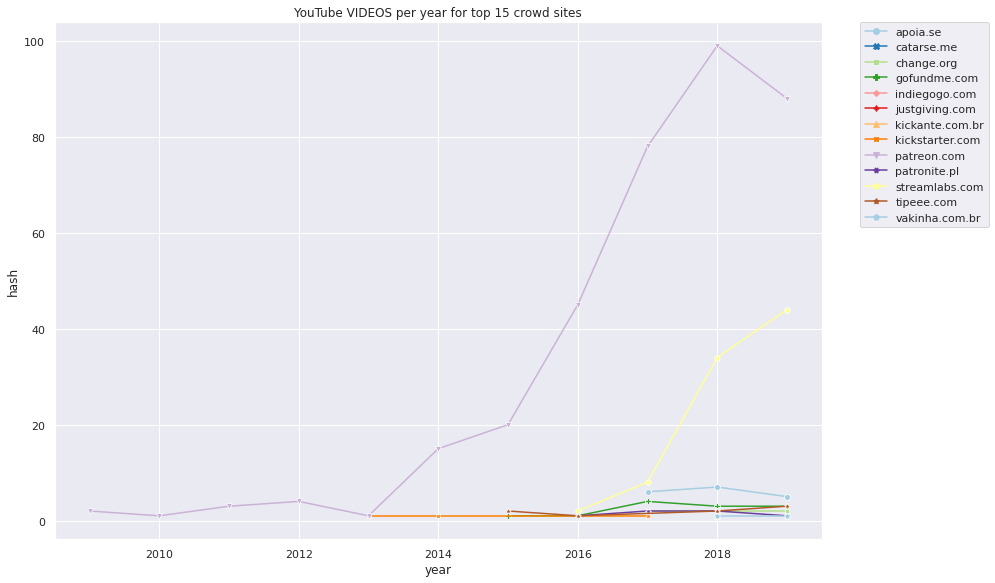

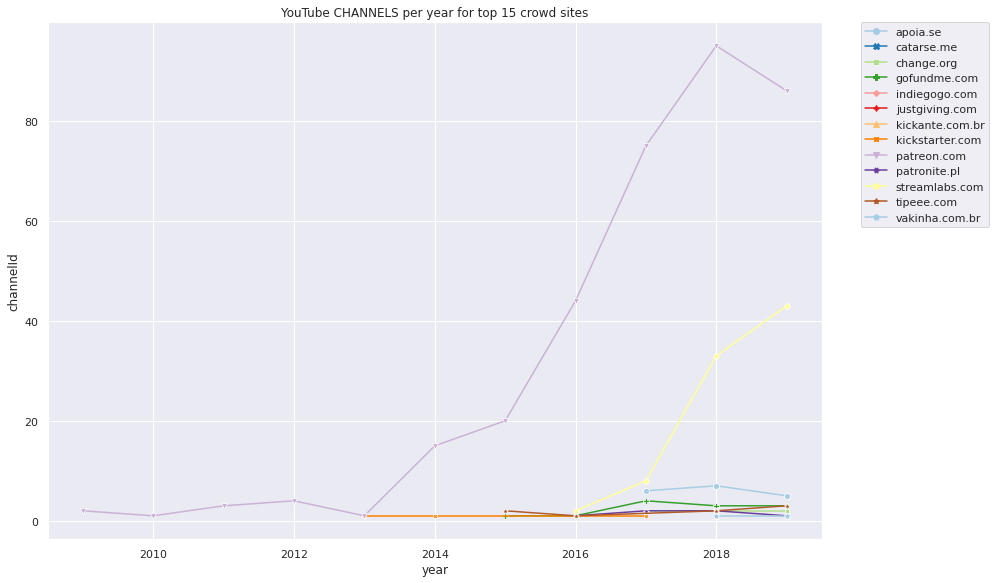

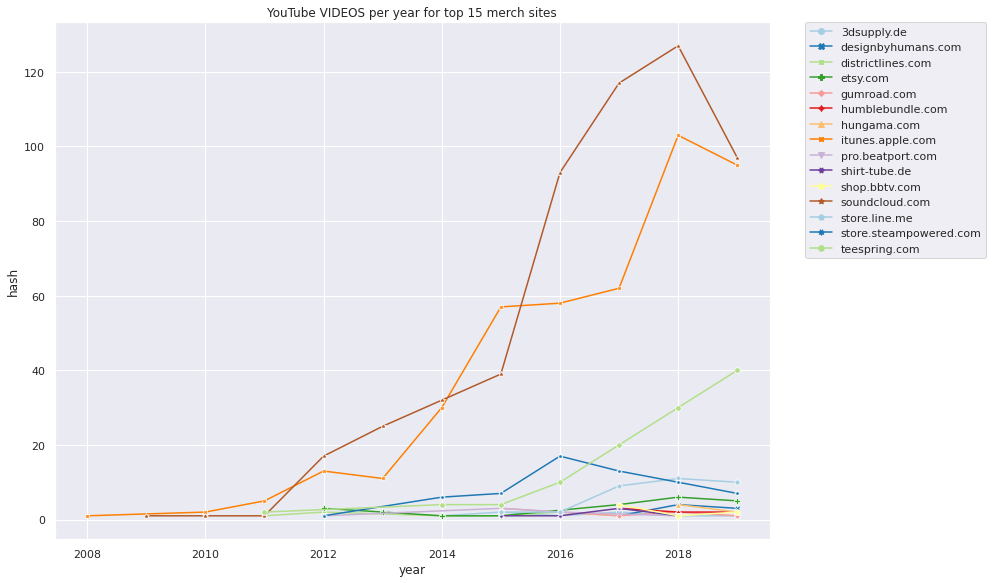

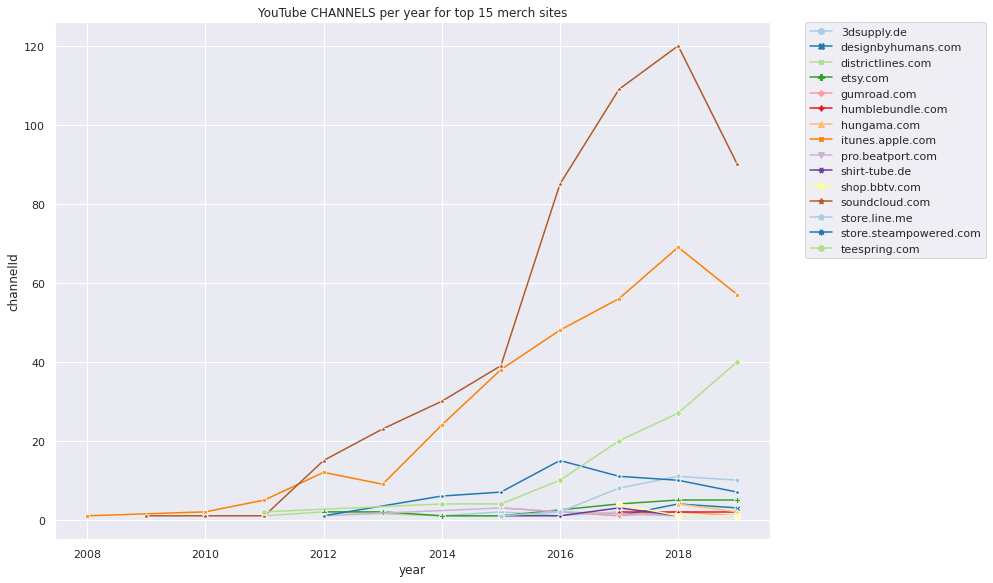

In [59]:
domain_stats = {}
for type in ['crowd','merch']:

    ''' Describe '''
    domain_stats[type] = pd_url_data[['domain','channelCountForDomain','videoCountForDomain','channelDivVideoForDomain']][pd_url_data[type]==True].drop_duplicates()

    # print header
    print("%s domain count" % type)
    # print most used TYPE domains
    print(domain_stats[type].sort_values(by=['channelCountForDomain','channelDivVideoForDomain'],ascending=False).head(limit))
    print("\n")
    # print TYPE domain stats
    print("%s domain stats" % type)
    print(domain_stats[type].describe())
    print("\n")

    ''' Graph '''

    # filter pd_url_data to only retain info for rows with TYPE domain
    filtered = {}
    filtered[type] = pd_url_data[pd_url_data[type]==True]

    # limit data by top overall TYPE domain for graph
    top_domains = {}
    top_domains[type] = domain_stats[type].sort_values(by="channelCountForDomain",ascending=False)['domain'][0:limit]
    filtered_limited = {}
    filtered_limited[type] = filtered[type][filtered[type]['domain'].isin(top_domains[type])==True]

    # get number of unique domains for color palette in graph 
    num_domains = {}
    num_domains[type] = len(filtered_limited[type]['domain'].unique())
    color_palette = {}
    color_palette[type] = sns.color_palette("Paired",n_colors=num_domains[type])

    # count videos by TYPE domain and year
    filtered_limited_count = {}
    filtered_limited_count[type] = filtered_limited[type].groupby(["domain","year"])['hash'].nunique()
    filtered_limited_count[type] = filtered_limited_count[type].to_frame()
    filtered_limited_count[type].reset_index(inplace=True)
    
    # plot rise of TYPE sites, for videos per year
    plt.figure()
    sns.lineplot(x="year", y="hash", hue="domain", style="domain", palette = color_palette[type], markers=True, dashes=False, data=filtered_limited_count[type])
    plt.title("YouTube VIDEOS per year for top %s %s sites" % (limit,type))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()

    # count channels by TYPE domain and year
    filtered_limited_count = {}
    filtered_limited_count[type] = filtered_limited[type].groupby(["domain","year"])['channelId'].nunique()
    filtered_limited_count[type] = filtered_limited_count[type].to_frame()
    filtered_limited_count[type].reset_index(inplace=True)

    # plot rise of TYPE sites, for channels per year
    plt.figure()
    sns.lineplot(x="year", y="channelId", hue="domain", style="domain", palette = color_palette[type], markers=True, dashes=False, data=filtered_limited_count[type])
    plt.title("YouTube CHANNELS per year for top %s %s sites" % (limit,type))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()


## @todo

* Work on the referral list
   * Observations
      * not all monetization sites are part of our list getshirts.de
      * Stuff definitely missing on our lists: getshirts.de, amazon.{tld}, banggood, aliexpress, skillshare, …
   * Get 1000 domains of all URLs (overall and based on channel)
      * Already qualify as crowd, merch, commission
      * Continue the rest of the sites and see whether they should be included or added to (other) list via emergent (grounded theory) coding
   * host (instead of domain)
* Overall observations
   * Background graph: number of URLs per year
   * Make RankFlow of top domains per year
   * How many domains for 80% coverage?
   * Domains, top deep links: add diversity
   * Why are there ⅓ of URLs going to youtube.com and what do they link to (videos, channels?) Are they building a network, just like featuring or subscribing?
* Rather than thinking about URLs, think about views/subscriber numbers.
* Is the presence of other platforms a sign of cross-platform activity?
* Look into the means of production, e.g. free audio
* Other
   * Breakdowns
   * subscriber tier
   * language & locale
   * category (channel & video)
   * year

Channel data set
* Fuse this with channels data set. Finding a way to use the URLs to characterize channels.
   * Channel categories. What hasn't been done at all in the last paper is looking at video categories. That may be done interestingly. Monetization per channel category. Channel classification is not done by video creators. 
	   * b = DataFrame(a.var1.str.split('|').tolist(), index=a.var2).stack()
	   * b = b.reset_index()[[0, 'var2']] # var1 variable is currently labeled 0
	   * b.columns = ['var1', 'var2'] # renaming var1
   * Merch and monetization per channel. When did they introduce this?
   * Whether channels changed merch or crowd-financing, giving that they not backport.
* Compare channel categories vs video categories. (But we need to import mysql database.) Is gonna be important when looking at descriptions and tags and such.
* Think of categories in terms of scatter plots. E.g. crowd funding vs merch and category. Size is number of videos.
* Via topic and/or video categories. E.g. gaming may have a very different URL profile then news/politics. 
* Merch stores with particular topical affinity (e.g. alt-right channels use store X) - alternative ways of classifying youtube. Otherway around: categories that are more suited to crowd-funding than others.

Various
* create list of "commission"
	* Official YT merch list = https://support.google.com/youtube/answer/6083754?hl=en#zippy=%2Clist-of-approved-merchandise-sites
* Domains: open.spotify.com, spotify.com, play.google.com, accounts.google.com, etc. (Does play.google.com has a commission?)

Alternative modes of classification? 
* For a channel we have channel description, keywords, all video titles and keywords. Run as a topic model.
* Video categories are unique and chosen by uploaders
* Channel category column can have several channels, is assigned done automatically by YouTube
* (channels have keywords too, which are much more descriptive. But long-tail, language specific)

Later
* what kind of channels linked to the academic publishers?
* look into what's missing. The "(note-)book" of the dead.
	* https://www.youtube.com/error?src=404
	* unacademy.com/unavailable
* graphs, instead of absolute numbers, divide into number of videos per year
* Patreon pledgers, crowd-funding sites/pledges.
* Collect ASINs. How many different products are being advertised (most popular producst - # videos, #views; youtube as amazon catalogue).
* Each URL may afford something for analysis.
* Cross-language analysis. (Videos have language, channels have country flag). 